In [1]:
import sys
#sys.path.append('../..')
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
#sys.path.insert(0, str(Path.cwd()))
%matplotlib inline

DATAROOT = Path('./urbansound8k') ## Set folder of your copy
df = pd.read_csv(DATAROOT/'metadata/UrbanSound8K.csv')
folds = list(set(df.fold))

In [2]:
#df.head()
df[0:10]

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


In [3]:
import pprint
# create a list of the class labels
labels = list(df['class'].unique())
# let's grab a single audio file from each class
files = dict()
for i in range(len(labels)):
    tmp = df[df['class'] == labels[i]][:1].reset_index()
    path = f'urbansound8k/audio/fold{tmp["fold"][0]}/{tmp["slice_file_name"][0]}'
    files[labels[i]] = path

pprint.pprint(files)


{'air_conditioner': 'urbansound8k/audio/fold5/100852-0-0-0.wav',
 'car_horn': 'urbansound8k/audio/fold10/100648-1-0-0.wav',
 'children_playing': 'urbansound8k/audio/fold5/100263-2-0-117.wav',
 'dog_bark': 'urbansound8k/audio/fold5/100032-3-0-0.wav',
 'drilling': 'urbansound8k/audio/fold3/103199-4-0-0.wav',
 'engine_idling': 'urbansound8k/audio/fold10/102857-5-0-0.wav',
 'gun_shot': 'urbansound8k/audio/fold1/102305-6-0-0.wav',
 'jackhammer': 'urbansound8k/audio/fold1/103074-7-0-0.wav',
 'siren': 'urbansound8k/audio/fold7/102853-8-0-0.wav',
 'street_music': 'urbansound8k/audio/fold7/101848-9-0-0.wav'}


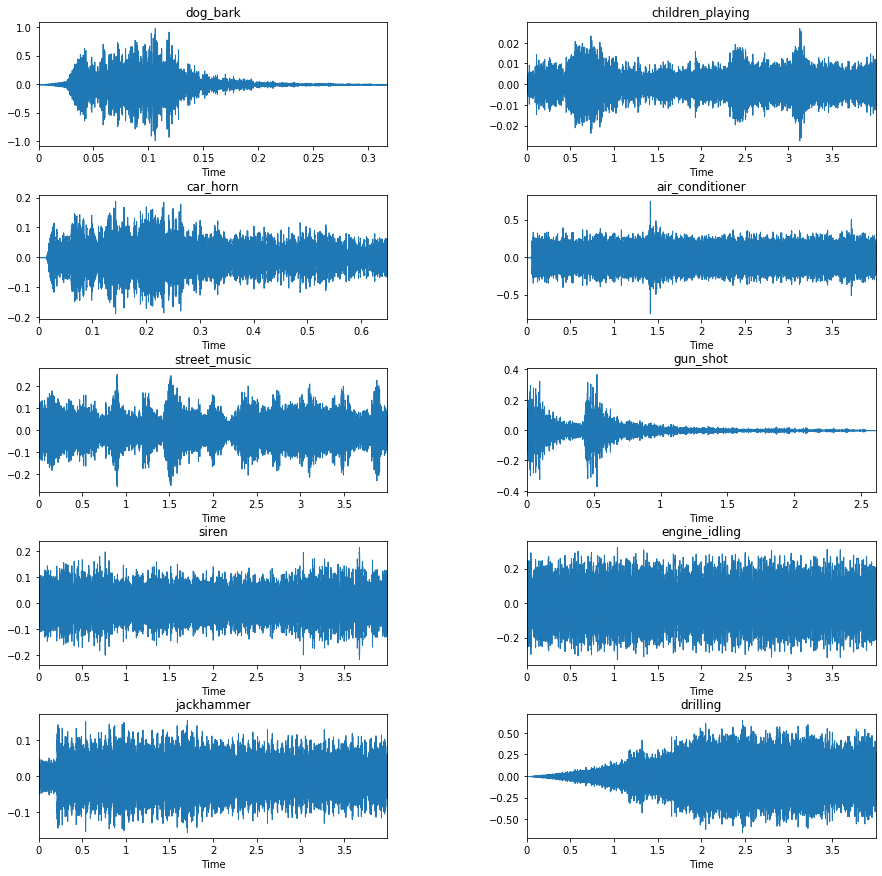

In [4]:
import librosa
import librosa.display

fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(labels):
    fn = files[label]
    fig.add_subplot(5, 2, i+1)
    plt.title(label)
    data, sample_rate = librosa.load(fn)
    librosa.display.waveplot(data, sr=sample_rate)
plt.savefig('class_examples.png')

# log graphic of waveforms to Comet
#experiment.log_image('class_examples.png')


# Extracting MFCCs from audio using Librosa¶

In [5]:
for label in labels:
    fn = files[label]

In [6]:
from scipy.io import wavfile as wav

fn = 'urbansound8k/audio/fold1/191431-9-0-66.wav'
librosa_audio, librosa_sample_rate = librosa.load(fn)
scipy_sample_rate, scipy_audio = wav.read(fn)
print(f'Scipy sample rate: {scipy_sample_rate}')
print(f'Librosa sample rate: {librosa_sample_rate}')


Scipy sample rate: 48000
Librosa sample rate: 22050


In [7]:
import numpy as np

print(f'Scipy audio file min~max range: {np.min(scipy_audio), np.max(scipy_audio)}')
print(f'Librosa audio file min~max range: {np.min(librosa_audio)}, {np.max(librosa_audio)}')


Scipy audio file min~max range: (-1869, 1665)
Librosa audio file min~max range: -0.047033071517944336, 0.04033438488841057


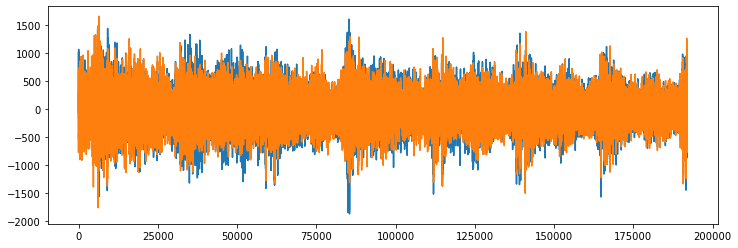

In [8]:

plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)
plt.savefig('scipy_audio.png')

In [9]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


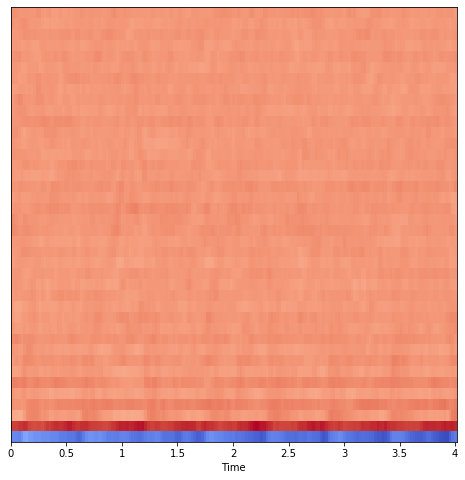

In [10]:
plt.figure(figsize=(8, 8))
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')
plt.savefig('MFCCs.png')

In [11]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T, axis=0)

    return mfccs_processed


In [13]:
import os 

features = []
FULL_DATASET_PATH = 'urbansound8k'
'''
# Convert data for each fold
for fold in folds:
    print(fold)
    cur_df =df[df.fold.isin([fold])]
    Xfiles = [str(DATAROOT/('fold%d' % (r.fold))/r.slice_file_name) for i, r in cur_df.iterrows()]
    y = [conf.label2int[r['class']] for i, r in cur_df.iterrows()]
    XX = mels_build_multiplexed_X(conf, Xfiles)
    X, y = mels_demux_XX_y(XX, y)
    np.save('X_fold%d.npy' % fold, X)
    np.save('y_fold%d.npy' % fold, y
'''            
# iterate through each sound file and extract the features

for index, row in df.iterrows():
    file_name = os.path.join(os.path.abspath(FULL_DATASET_PATH), 'audio/fold'+str(row['fold']) + '/', str(row['slice_file_name']))
    class_label = row['class']
    data = extract_features(file_name)
    features.append([data, class_label])




/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]


In [14]:
# convert into a pandas dataframe
featuresdf = pd.DataFrame(features, columns=['feature', 'class_label'])
featuresdf.head()
featuresdf.to_pickle('featuresdf.pkl')
featuresdf.to_csv('featuresdf.csv', index=False)

In [15]:
featuresdf = pd.read_pickle('featuresdf.pkl')
featuresdf.head()
#featuresdf.columns = ['feature', 'label']


,feature,class_label
0,"[-215.79301, 71.66612, -131.81377, -52.09133, ...",dog_bark
1,"[-424.68677, 110.56227, -54.148235, 62.01074, ...",children_playing
2,"[-459.56467, 122.800354, -47.92471, 53.265697,...",children_playing
3,"[-414.55377, 102.896904, -36.66495, 54.18041, ...",children_playing
4,"[-447.397, 115.0954, -53.809113, 61.60859, 1.6...",children_playing


We’ll start by converting our MFCCs to numpy arrays, and encoding our classification labels.

In [16]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))


Using TensorFlow backend.


Our dataset will be split into training and test sets.

In [22]:
# split the dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state=127)


In [23]:
print(x_test.shape)
print(y_test.shape)

(1747, 40)
(1747, 10)


Let’s define and compile a simple feedforward neural network architecture. Also we'll train the network using Bayesian Optimization.

In [24]:
num_labels = yy.shape[1]

print(num_labels)

print(x_train.shape)
print(y_train.shape)



10
(6985, 40)
(6985, 10)


# Model Structure

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


model = keras.Sequential()
model.add(layers.Dense(512, activation="relu", input_shape=(40,),name="layer1"))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation="relu",name="layer2"))
model.add(layers.Dropout(0.5))



model.add(layers.Dense(num_labels, activation="softmax",name="layer3"))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 512)               20992     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
layer2 (Dense)               (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
layer3 (Dense)               (None, 10)                2570      
Total params: 154,890
Trainable params: 154,890
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
110/110 [==============================] - 1s 5ms/step - loss: 0.6899 - accuracy: 0.7609 - val_loss: 0.5850 - val_accuracy: 0.8128
Epoch 2/100
110/110 [==============================] - 1s 5ms/step - loss: 0.6743 - accuracy: 0.7691 - val_loss: 0.5892 - val_accuracy: 0.8203
Epoch 3/100
110/110 [==============================] - 1s 5ms/step - loss: 0.6529 - accuracy: 0.7772 - val_loss: 0.5745 - val_accuracy: 0.8248
Epoch 4/100
110/110 [==============================] - 1s 5ms/step - loss: 0.6242 - accuracy: 0.7854 - val_loss: 0.5525 - val_accuracy: 0.8306
Epoch 5/100
110/110 [==============================] - 1s 5ms/step - loss: 0.6403 - accuracy: 0.7824 - val_loss: 0.5408 - val_accuracy: 0.8392
Epoch 6/100
110/110 [==============================] - 1s 5ms/step - loss: 0.6085 - accuracy: 0.7934 - val_loss: 0.5429 - val_accuracy: 0.8306
Epoch 7/100
110/110 [==============================] - 1s 5ms/step - loss: 0.5948 - accuracy: 0.7956 - val_loss: 0.5170 - val_accuracy: 0.8432

Epoch 58/100
110/110 [==============================] - 0s 4ms/step - loss: 0.3585 - accuracy: 0.8829 - val_loss: 0.3580 - val_accuracy: 0.9027
Epoch 59/100
110/110 [==============================] - 0s 5ms/step - loss: 0.3657 - accuracy: 0.8766 - val_loss: 0.3507 - val_accuracy: 0.9027
Epoch 60/100
110/110 [==============================] - 1s 5ms/step - loss: 0.3597 - accuracy: 0.8809 - val_loss: 0.3498 - val_accuracy: 0.9056
Epoch 61/100
110/110 [==============================] - 1s 5ms/step - loss: 0.3548 - accuracy: 0.8819 - val_loss: 0.3656 - val_accuracy: 0.9038
Epoch 62/100
110/110 [==============================] - 1s 5ms/step - loss: 0.3633 - accuracy: 0.8827 - val_loss: 0.3650 - val_accuracy: 0.8993
Epoch 63/100
110/110 [==============================] - 0s 4ms/step - loss: 0.3603 - accuracy: 0.8770 - val_loss: 0.3678 - val_accuracy: 0.8975
Epoch 64/100
110/110 [==============================] - 0s 4ms/step - loss: 0.3490 - accuracy: 0.8819 - val_loss: 0.3716 - val_accuracy:

In [27]:
model.history

# save model

In [28]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    model.save_weights("weights.h5") # serialize weights to HDF5

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)


# Implementing XGBOOST Algorithm on same Dataset¶


In [ ]:
train = np.argmax(y_train,axis =  1)

In [ ]:
train.shape

In [ ]:
x =x_train
x_train.shape

In [ ]:
test = np.argmax(y_test,axis =  1)

In [ ]:
from xgboost import XGBClassifier

In [ ]:
model = XGBClassifier(learning_rate =0.1, 
                      n_estimators=280, 
                      max_depth=5,
                      min_child_weight=1, 
                      gamma=0, 
                      subsample=0.8, 
                      colsample_bytree=0.8,
                      objective= 'binary:logistic', 
                      nthread=4, 
                      scale_pos_weight=1, 
                      seed=60)


In [ ]:
model.fit(x,train)

In [ ]:
pred = model.predict(x_test)


In [ ]:
test

In [ ]:
pred

In [ ]:
import sklearn.metrics as met
met.accuracy_score(test, pred)

In [ ]:
met.confusion_matrix(test, pred)